In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import json 

import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from preprocessor import get_train_environment

# Tuning model

In [2]:
# Define parameter grid
n_estimators = list(range(100, 1000, 100))
max_depth = list(range(2, 6, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = None
best_score = 0
model_performance = []

# Iterate over all combinations of parameters
for n, d in param_grid:
    acc_scores = []
    print(n,d)
    
    # Iterate over folds
    envGen = get_train_environment(n_splits=5)
    stats, X, X_holdout, y, y_holdout = next(envGen)
    
    for fold, stats, X_train, X_test, y_train, y_test in envGen:
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping empty fold: {fold}")
            continue
        class_y_train = [0 if value == 0 else 1 for value in y_train]
        class_y_test = [0 if value == 0 else 1 for value in y_test]
        # Create and fit the model
        model = RandomForestClassifier(n_estimators=n, max_depth=d)
        model.fit(X_train, class_y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        # Check if predictions are valid
        if not np.any(np.isnan(predictions)):
            acc = accuracy_score(class_y_test, predictions)
            acc_scores.append(acc)
            performance = {
                'n_estimators': n,
                'max_depth': d,
                'Fold':fold,
                'Accuracy': acc
            }
            model_performance.append(performance)
        else:
            print(f"Invalid predictions in fold: {fold}")       

    # Average Accuracy across folds for current parameter combination
    avg_acc = np.mean(acc_scores)
    # Update best parameters if current combination is better
    if avg_acc > best_score:
        best_score = avg_acc
        best_params = (n, d)


100 2
Found cached folds, using those
100 3
Found cached folds, using those
100 4
Found cached folds, using those
100 5
Found cached folds, using those
200 2
Found cached folds, using those
200 3
Found cached folds, using those
200 4
Found cached folds, using those
200 5
Found cached folds, using those
300 2
Found cached folds, using those
300 3
Found cached folds, using those
300 4
Found cached folds, using those
300 5
Found cached folds, using those
400 2
Found cached folds, using those
400 3
Found cached folds, using those
400 4
Found cached folds, using those
400 5
Found cached folds, using those
500 2
Found cached folds, using those
500 3
Found cached folds, using those
500 4
Found cached folds, using those
500 5
Found cached folds, using those
600 2
Found cached folds, using those
600 3
Found cached folds, using those
600 4
Found cached folds, using those
600 5
Found cached folds, using those
700 2
Found cached folds, using those
700 3
Found cached folds, using those
700 4
Found 

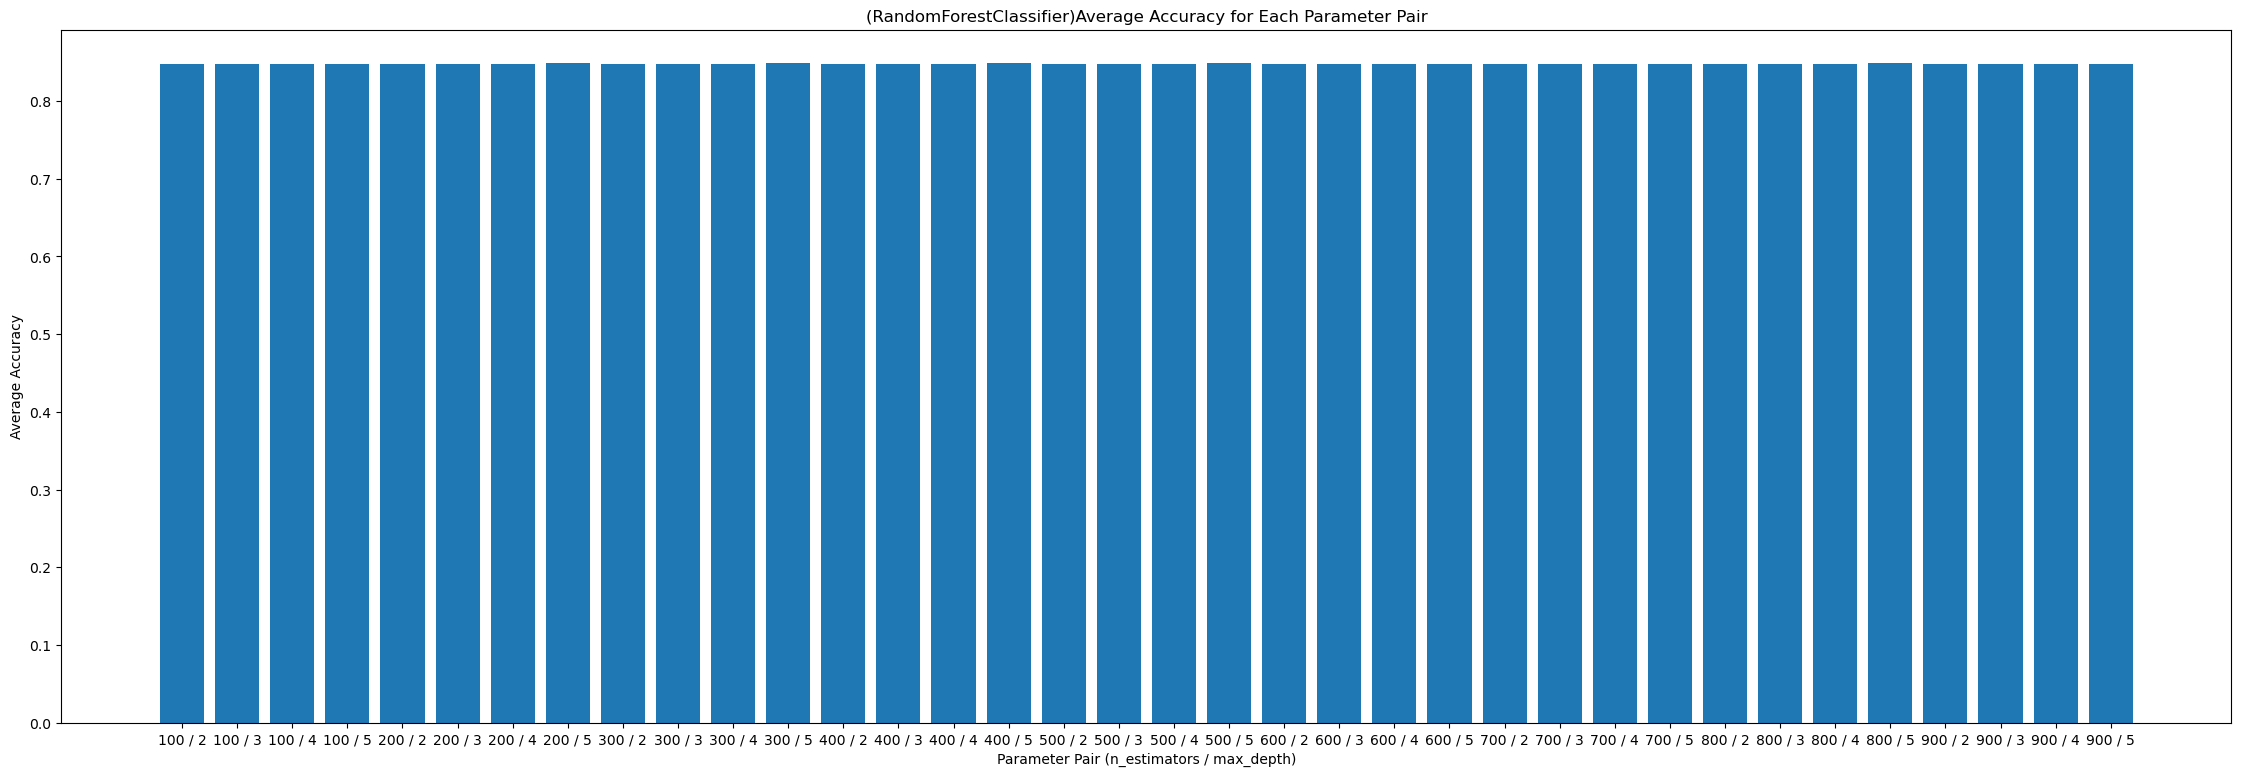

In [3]:
# Aggregate Accuracy values for each (n_estimators, max_depth) pair
acc_aggregate = {}

for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in acc_aggregate:
        acc_aggregate[key] = []
    acc_aggregate[key].append(entry['Accuracy'])

# Calculate average Accuracy for each pair
average_acc = {k: sum(v)/len(v) for k, v in acc_aggregate.items()}

# Prepare data for plotting
n_estimators = [k[0] for k in average_acc.keys()]
max_depth = [k[1] for k in average_acc.keys()]
avg_acc = list(average_acc.values())

plt.figure(figsize=(28,9))
plt.bar(range(len(avg_acc)), avg_acc, tick_label=[f"{n} / {d}" for n, d in zip(n_estimators, max_depth)])
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average Accuracy')
plt.title('(RandomForestClassifier)Average Accuracy for Each Parameter Pair')
plt.show()

In [4]:
print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with Accuracy: {best_score}")

Best parameters: n_estimators=200, max_depth=5 with Accuracy: 0.849610672009596


# Find important feature

In [5]:
envGen = get_train_environment(n_splits=5)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Initialize variables to track important features num
print(len(X[0]))
featureNums = range(1, len(X[0]), 10)
featureNumaccs = {}

# Cross validation folds
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train]
    class_y_test = [0 if value == 0 else 1 for value in y_test]
    
    model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train, class_y_train)

    # print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    acc = accuracy_score(class_y_test, predictions)
    print("Overall Fold Accuracy: ", acc)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    eps = 0.00001
    lastacc = None
    for featureNum in featureNums:
        selectedFeatures = [i for i, x in thresholds[:featureNum]]
        
        model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1])
        XT = X_train[:, selectedFeatures]
        model.fit(XT, class_y_train)
        
        predictions = model.predict(X_test[:, selectedFeatures])
        acc = accuracy_score(class_y_test, predictions)
        
        if lastacc is not None:
            if np.abs(acc - lastacc) < eps:
                print(np.abs(acc - lastacc))
                print(acc)
                break
            else:
                lastacc = acc
        else:
            lastacc = acc
        
        if featureNum in featureNumaccs:
            featureNumaccs[featureNum].append(acc)
        else:
            featureNumaccs[featureNum] = [acc]
        
        print(f"FeatureNum: {featureNum}")
        print("FeatureNum Accuracy: ", acc)

avgFeatureNumaccs = {x: np.mean(featureNumaccs[x]) for x in featureNumaccs}
optimal_FeatureNum = [max(avgFeatureNumaccs, key=avgFeatureNumaccs.get),avgFeatureNumaccs[max(avgFeatureNumaccs, key=avgFeatureNumaccs.get)]]
print("Optimal # of features: ",optimal_FeatureNum[0],", Accuracy: ",optimal_FeatureNum[1])

Found cached folds, using those
1574
Fold: 0
Overall Fold Accuracy:  0.8446909667194928
FeatureNum: 1
FeatureNum Accuracy:  0.9276281035393555
FeatureNum: 11
FeatureNum Accuracy:  0.9619651347068146
0.0
0.9619651347068146
Fold: 1
Overall Fold Accuracy:  0.8372952984680402
FeatureNum: 1
FeatureNum Accuracy:  0.93608029582673
FeatureNum: 11
FeatureNum Accuracy:  0.9587955625990491
FeatureNum: 21
FeatureNum Accuracy:  0.9619651347068146
FeatureNum: 31
FeatureNum Accuracy:  0.9630216587427364
FeatureNum: 41
FeatureNum Accuracy:  0.9577390385631274
0.0
0.9577390385631274
Fold: 2
Overall Fold Accuracy:  0.8472515856236786
FeatureNum: 1
FeatureNum Accuracy:  0.9371035940803383
FeatureNum: 11
FeatureNum Accuracy:  0.9630021141649049
FeatureNum: 21
FeatureNum Accuracy:  0.9619450317124736
FeatureNum: 31
FeatureNum Accuracy:  0.9608879492600423
FeatureNum: 41
FeatureNum Accuracy:  0.9550739957716702
FeatureNum: 51
FeatureNum Accuracy:  0.9571881606765328
FeatureNum: 61
FeatureNum Accuracy:  0.94

Text(0.5, 1.0, 'RandomForestClassifier feature number vs Accuracy')

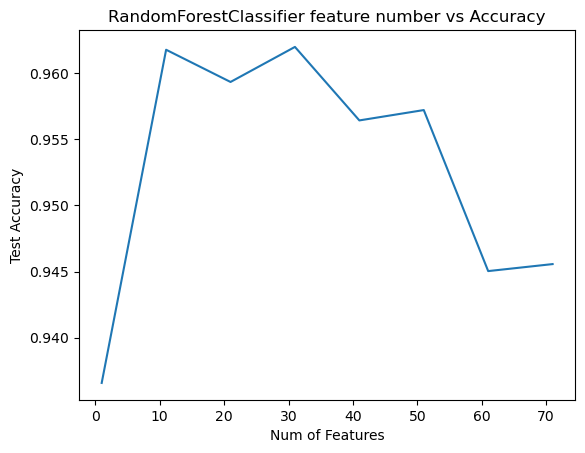

In [6]:
ax = sns.lineplot(pd.Series(avgFeatureNumaccs))
ax.set_xlabel("Num of Features")
ax.set_ylabel("Test Accuracy")
ax.set_title("RandomForestClassifier feature number vs Accuracy")

# Create final RFClassifier model after tuning & select important features

In [7]:
envGen = get_train_environment(n_splits=50)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

final_accs = []
final_selection_intersection = set()
allSelecteds = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train_fold]
    class_y_test = [0 if value == 0 else 1 for value in y_test_fold]
    
    model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train_fold, class_y_train)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    pre_predictions = model.predict(X_test_fold)

    pre_acc = accuracy_score(class_y_test, pre_predictions)
    print("Pre Selection Accuracy: ", pre_acc)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    selectedFeatures = [i for i, x in thresholds[:optimal_FeatureNum[0]]]
    allSelecteds.append(selectedFeatures)
    
    if len(final_selection_intersection) == 0:
        final_selection_intersection = final_selection_intersection.union(selectedFeatures)
    else:
        final_selection_intersection = final_selection_intersection.intersection(selectedFeatures)
    
    model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    
    XT = X_train_fold[:, selectedFeatures]
    model.fit(XT, class_y_train)

    post_predictions = model.predict(X_test_fold[:, selectedFeatures])
    post_acc = accuracy_score(class_y_test, post_predictions)
    print("Post Selection Accuracy: ", post_acc)
    final_accs.append(post_acc)

Found cached folds, using those
Fold: 0
[0.01592143 0.03661045 0.002509   ... 0.00954842 0.00379064 0.0053226 ]
Pre Selection Accuracy:  0.8947368421052632
Post Selection Accuracy:  0.9789473684210527
Fold: 1
[0.01206443 0.04248015 0.00219336 ... 0.01914232 0.00317129 0.00323528]
Pre Selection Accuracy:  0.8315789473684211
Post Selection Accuracy:  0.9526315789473684
Fold: 2
[0.0091798  0.04894364 0.00149478 ... 0.01202358 0.00535682 0.00570912]
Pre Selection Accuracy:  0.8947368421052632
Post Selection Accuracy:  0.9421052631578948
Fold: 3
[0.00948948 0.04481134 0.00116489 ... 0.01321976 0.00406714 0.0048111 ]
Pre Selection Accuracy:  0.7947368421052632
Post Selection Accuracy:  0.968421052631579
Fold: 4
[0.01105343 0.04571533 0.00312296 ... 0.02329489 0.00407615 0.0058074 ]
Pre Selection Accuracy:  0.8631578947368421
Post Selection Accuracy:  0.9631578947368421
Fold: 5
[0.01201693 0.04737233 0.00101734 ... 0.01382928 0.00244949 0.00457703]
Pre Selection Accuracy:  0.8210526315789474


In [8]:
print("Final RFClassifier model's avg. Accuracy:",np.mean(final_accs))

Final RFClassifier model's avg. Accuracy: 0.9589958228905595


In [9]:
def feature_labels(features):
    data = pd.read_csv("FinalData.csv")
    data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
    data_columns = data.columns.tolist()
    return [x for i, x in enumerate(data_columns) if i in features]

In [10]:
rf_class_final_features = feature_labels(final_selection_intersection)
print(rf_class_final_features)

['release_date', 'Single-player', 'Steam Achievements', 'Full controller support', 'Steam Trading Cards', 'Steam Cloud', 'Profile Features Limited', 'tag_Free to Play', 'In-App Purchases', 'tag_Clicker', 'tag_Idler', 'genre_Massively Multiplayer', 'MMO', 'tag_Massively Multiplayer', 'ln.curatorsp1', 'ln.steam_achievementsp1', 'ln.interfacep1', 'ln.subtitlesp1']
